<a href="https://colab.research.google.com/github/luke-t-menezes/pxrd_statistics_tutorial/blob/main/pxrd_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial of PXRD Statistics

## Introduction

For this demo, we will cover the statistics commonly used to assess the goodness-of-fit of X-ray diffraction experimental data to theoretical models. Powder X-ray diffraction (PXRD) is a powerful and convenient technique for determining the composition and atomic structure of crystalline materials. A simple PXRD experiment involves bombarding a powder sample with X-rays (typically Cu Kα radiation in a lab setting) and detecting the angles at which X-rays are scattered off the sample. Since the diffraction condition relies upon the charcateristic lattice spacing in a crystalline material, the identity of the components of the sample may be identified.

Rietveld refinements are widely used in solid-state chemistry and materials science to determine sample composition from PXRD data. A popular software package for performing Rietveld refinements is GSAS-II (https://advancedphotonsource.github.io/GSAS-II-tutorials/). All Rietveld refinements start with a structural model of the material you believe to be in your sample, or one that is similar enough to the material in your sample. The process of refining involves making adjustments to your starting model such that it's simulated PXRD pattern resembles the experimental pattern more and more with each successive step. **The goal of the Rietveld refinementis to minimize the difference between the simulated PXRD pattern based on your structural model and your experimental diffraction pattern.**

We won't be using GSAS-II directly in this demo; that is beyond the scope of this tutorial. Rather, we will be looking at the goodness-of-fit metrics throughout different stages of a refinement. When reporting the results of Rietveld refinements the metrics that we care about are the residual factor(*R*) and χ<sup>2</sup> (pronounced chi-squared). Both or these metrics tell us about the cumulative difference in the simulated and experimental intensity data. Poor fits (the simulated pattern doesn't align with the experimental pattern at all) correspond to large *R* and χ<sup>2</sup> values.

In [41]:
# Install ASE to visualize crystal structures
!pip install ase # ~10 seconds

# Import necessary libraries
from ase.io import read
from ase.visualize.plot import plot_atoms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The relavent PXRD data will be downloaded from Github, as well as the crystal structures which are contained inside crystallographic information files (CIF). CIF files are a standard text file format for documentaing crystallographic information.

In [42]:
# Download a CIF files
cif_urls = ['https://raw.githubusercontent.com/luke-t-menezes/pxrd_statistics_tutorial/main/cifs/Gd2Zr2O7.cif',
             'https://raw.githubusercontent.com/luke-t-menezes/pxrd_statistics_tutorial/main/cifs/Gd3Fe5O12.cif']

cif_files = ['Gd2Zr2O7.cif',
             'Gd3Fe5O12.cif']

for url, f in zip(cif_urls, cif_files):
  !wget -O {f} {url}

--2026-01-14 22:36:34--  https://raw.githubusercontent.com/luke-t-menezes/pxrd_statistics_tutorial/main/cifs/Gd2Zr2O7.cif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5629 (5.5K) [text/plain]
Saving to: ‘Gd2Zr2O7.cif’

Gd2Zr2O7.cif        100%[===================>]   5.50K  --.-KB/s    in 0s      

2026-01-14 22:36:35 (62.0 MB/s) - ‘Gd2Zr2O7.cif’ saved [5629/5629]

--2026-01-14 22:36:35--  https://raw.githubusercontent.com/luke-t-menezes/pxrd_statistics_tutorial/main/cifs/Gd3Fe5O12.cif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

In [43]:
# Download a data files containing 2theta and intensity
data_urls = ['https://raw.githubusercontent.com/luke-t-menezes/pxrd_statistics_tutorial/main/data/stage1.csv',
             'https://raw.githubusercontent.com/luke-t-menezes/pxrd_statistics_tutorial/main/data/stage2.csv',
             'https://raw.githubusercontent.com/luke-t-menezes/pxrd_statistics_tutorial/main/data/stage3.csv',
             'https://raw.githubusercontent.com/luke-t-menezes/pxrd_statistics_tutorial/main/data/stage4.csv']

stages = ['stage1.csv',
          'stage2.csv',
          'stage3.csv',
          'stage4.csv']


for url, stage in zip(data_urls, stages):
  !wget -O {stage} {url}


--2026-01-14 22:36:35--  https://raw.githubusercontent.com/luke-t-menezes/pxrd_statistics_tutorial/main/data/stage1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 556424 (543K) [text/plain]
Saving to: ‘stage1.csv’

stage1.csv          100%[===================>] 543.38K  --.-KB/s    in 0.04s   

2026-01-14 22:36:35 (12.4 MB/s) - ‘stage1.csv’ saved [556424/556424]

--2026-01-14 22:36:35--  https://raw.githubusercontent.com/luke-t-menezes/pxrd_statistics_tutorial/main/data/stage2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

In [44]:
# A handy plotting function to visualize the PXRD data we've just downloaded.
def plot_pxrd(filename:str, figsize:tuple=(12, 6), xlim:tuple=(20, 80)):
    # Read the data
    df = pd.read_csv(filename, sep=',')

    # Get column names
    ttheta_col = [col for col in df.columns if '2theta' in col][0]

    # Create single plot
    fig, ax = plt.subplots(figsize=figsize)

    # Plot: Observed, Calculated, Background, and Difference
    ax.plot(df[ttheta_col], df['obs'], 'ko', markersize=2, label='Observed', alpha=0.6)
    ax.plot(df[ttheta_col], df['calc'], 'r-', linewidth=2.5, label='Calculated')
    ax.plot(df[ttheta_col], df['bkg'], 'g-', linewidth=2.5, label='Background')
    ax.plot(df[ttheta_col], df['diff'], 'b-', linewidth=2.5, label='Difference')

    ax.set_xlabel('2θ (degrees)', fontsize=12)
    ax.set_ylabel('Intensity (counts)', fontsize=12)
    ax.legend(loc='upper right', fontsize=10)
    ax.set_xlim(xlim)

    plt.tight_layout()
    plt.show()

## Stage 1: Fit PXRD with a Single Phase

In this demo, we will examine the experimental PXRD data for a powder sample prepared by high-temperature solid-state synthesis. The synthesis procedure involved mixing the precursors Gd<sub>2</sub>O<sub>3</sub>, Fe<sub>2</sub>O<sub>3</sub>, and ZrO<sub>2</sub> into a homogeneous powder and annealing the mixture in air inside of a high-temperature furnace at 1200°C for 48 h. The sample was then removed from the furnace and analyzed via PXRD.

The product of this reaction was expected to be Gd<sub>2</sub>Zr<sub>2</sub>O<sub>7</sub> which adopts the defect-fluorite crystal structure, a derivative of the face-centered cubic (FCC) crystal structure. Below we use ASE to visualize the defect-fluorite crystal structure. The atomic coordinates for this structure are:

| Label | Atom | x | y | z | Occupancy | Multiplicity |
| -- | -- | -- | -- | -- | -- | -- |
| Gd1 | Gd | 0 | 0 | 0 | 0.5 | 4 |
| Zr1 | Zr | 0 | 0 | 0 | 0.5 | 4 |
| O1 | O | 0.25 | 0.25 | 0.25 | 0.875 | 8 |

Note the original chemical formula can be recovered by multiplying the site occupancy by the multiplicty of the site i.e. Gd<sub>0.5x4</sub>Zr<sub>0.5x4</sub>O<sub>0.875x8</sub>. The fractional occupancies indicate that there is a 50/50 chance of finding either a Gd atom or a Zr atom at that site in the crystal lattice. Note the O1 site is not 100% occupied meaning 12.5% of these sites are vacant.






Number of atoms per unit cell: 12
Cell parameters: [ 5.516052  5.516052  5.516052 90.       90.       90.      ]


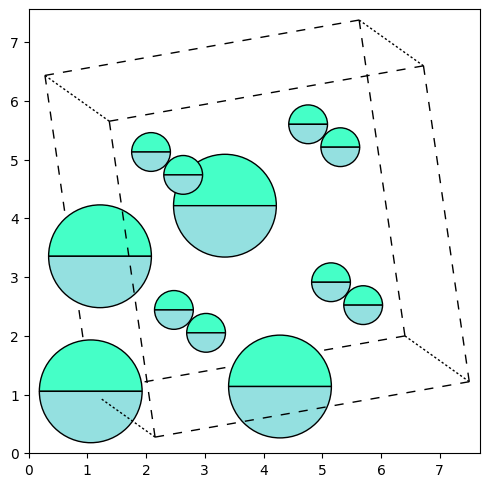

In [45]:
# Read the CIF file
atoms = read('Gd2Zr2O7.cif')

# Print basic structure information

print(f"Number of atoms per unit cell: {len(atoms)}")
print(f"Cell parameters: {atoms.cell.cellpar()}")

# Plot the structure
fig, ax = plt.subplots(figsize=(5, 5))
plot_atoms(atoms, ax, radii=0.5, rotation=('10x,10y,10z'))
plt.tight_layout()
plt.show()


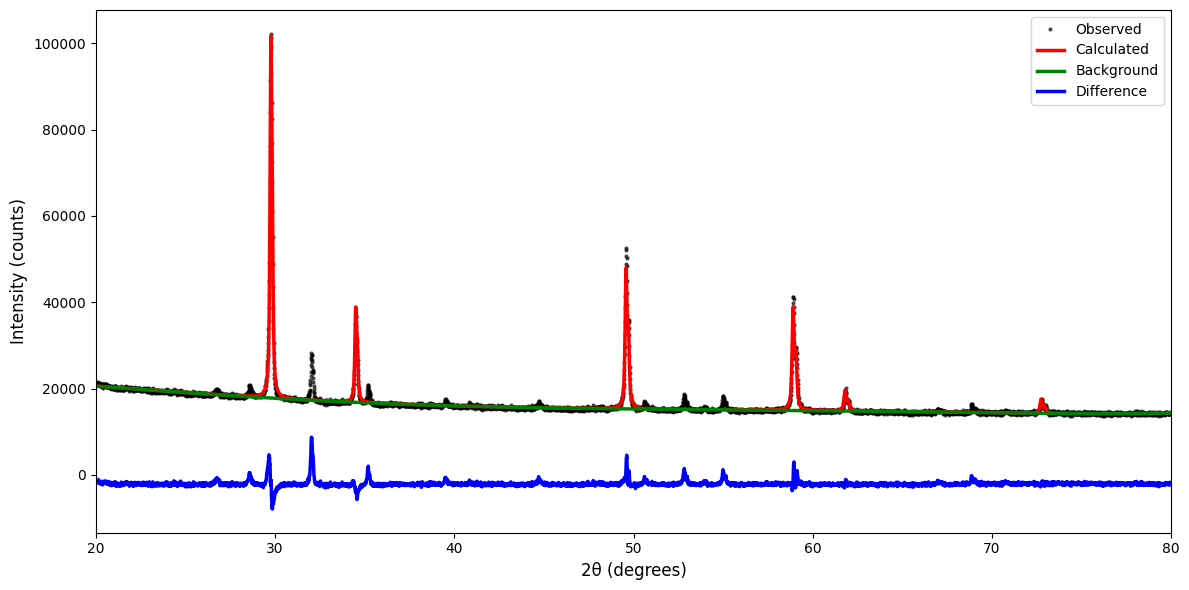

In [46]:
# Plot the experimenetal and calculated PXRD patterns
plot_pxrd('stage1.csv')

Above is the fit of the defect-fluorite structure to the experimental pattern. Obviousy, it is pretty clear that this is not a great fit -- there are a lot of unacounted for diffraction peaks in this PXRD pattern.

### Calculate *R* factors and Χ<sup>2</sup>

In a X-ray diffraction experiment X-ray photons are scattered off the surface of the sample and picked up by a detector scanning over a range of 2Θ values. The experimentaly observed intensity (y<sub>obs,i</sub>) intensity is then recorded at each step in 2Θ. The calculated intensity (y<sub>calc,i</sub>) is calculated from the *structure factor* (https://en.wikipedia.org/wiki/Structure_factor) which depends on the atomic species and their locations inside the unit cell.

Not every scattered X-ray photon will enter the detector at a given angle. Therefore, the intensity at a given interval must be modeled with a *Poisson distribution* (https://en.wikipedia.org/wiki/Poisson_distribution). Poisson distributions are used whenever events (like counting photons) occur randomly over a given interval (2θ range).

As a result, y<sub>obs,i</sub> is not the **true** intensity, which must be estimated. If the true intensity (y<sub>true,i</sub>) could be known—say, by measuring for an infinite amount of time—then on average, y<sub>obs,i</sub> would be within ±σ[y<sub>obs,i</sub>] of y<sub>true,i</sub>, where σ[y<sub>obs,i</sub>] is the standard uncertainty of the measurement. For counting experiments like XRD then the y<sub>obs,i</sub> = σ<sup>2</sup>[y<sub>obs,i</sub>]

The standard uncertainty (σ) can be incorporated into our metrics as a weighting factor (w<sub>i</sub>). In practice, GSAS-II simply estimates σ<sup>2</sup>[y<sub>obs,i</sub>] as being equal to y<sub>obs,i</sub> which is what we will also do:

$$w_i = 1/σ^2[y_{obs,i}] ≈ 1/y_{obs,i}$$


Now we have everything we need to calculate our metrics.

Firstly, the weighted profile residual-factor *R*<sub>wp</sub> is given by:

$$ R_{wp}^2 = \frac{\sum(w_i(y_{calc,i}-y_{obs,i})^2)}{\sum(w_i(y_{obs,i})^2)}$$

This is the quantitiy that Rietveld refinement's try to minimize when adjusting the structural model.



In [47]:
def calculate_rwp(obs, calc):
    # Guard against dividing by 0
    mask = obs > 0

    obs_masked = obs[mask]
    calc_masked = calc[mask]
    weights = 1.0 / obs_masked  # w = 1/sigma^2 = 1/obs for Poisson statistics

    numerator = np.sum((weights * (calc_masked - obs_masked)**2))
    denominator = np.sum(weights * (obs_masked)**2)
    rwp = np.sqrt(numerator / denominator)

    return rwp

The expected *R*-factor, *R*<sub>exp,i</sub>, may be regarded as the "best possible" *R*-factor achievable. It only takes into acount the observed intensities:

$$ R_{exp}^2 = \frac{N}{\sum(w_i(y_{obs,i})^2)}$$

Where *N* is the number of datapoints in the diffraction pattern.



In [48]:
def calculate_rexp(obs):
    mask = obs > 0

    obs_masked = obs[mask]
    weights = 1.0 / obs_masked
    N = len(obs_masked)

    denominator = np.sum(weights * (obs_masked)**2)
    rexp = np.sqrt((N) / denominator)

    return rexp

Finally, Χ<sup>2</sup> is simply the average difference between the intensity corrected y<sub>obs,i</sub> and y<sub>calc,i</sub>:

$$ χ^2 = \frac{1}{N}\sum \frac{(y_{obs,i}-y_{calc,i})^2}{σ^2[y_{obs,i}]}$$

Therefore, Χ<sup>2</sup> may also be written as:

$$ χ^2 = (\frac{R_{wp}}{R_{exp}})^2$$

Useful resource: https://www.cambridge.org/core/journals/powder-diffraction/article/r-factors-in-rietveld-analysis-how-good-is-good-enough/17439A1F889B689C495549A234D53682


In [49]:
def calculate_chi_squared(obs, calc):
    rwp = calculate_rwp(obs, calc)
    rexp = calculate_rexp(obs)

    chi2 = (rwp / rexp)**2

    return chi2

In [50]:
# Calculate chi-squared for Stage 1
df = pd.read_csv('stage1.csv', sep=',')
obs = df['obs'].values
calc = df['calc'].values

print(f'Rwp: {calculate_rwp(obs, calc):.4f} ({calculate_rwp(obs, calc)*100:.2f}%)')
print(f'Rexp: {calculate_rexp(obs):.4f} ({calculate_rexp(obs)*100:.2f}%)')
print(f'chi-squared: {calculate_chi_squared(obs, calc):.4f}')

Rwp: 0.0374 (3.74%)
Rexp: 0.0078 (0.78%)
chi-squared: 23.2699


### Stage 2: Add a second phase

There is a prominent peak at 32° that is not correspond to any of the peaks of the defect fluorite structure. At this point one would probably go to a lookup table for compounds that contain Gd, Fe, Zr, and O and see if any of them have a peak around 32°. You won't have to look too hard before you see that the PXRD pattern of Gd<sub>3</sub>Fe<sub>5</sub>O<sub>12</sub> has an intense peak at precisely that location. Below we can visualize the crystal structure of Gd<sub>3</sub>Fe<sub>5</sub>O<sub>12</sub>. It may look complicated but this is actually the garnet crystal structure and it's relatively common among oxides.

/usr/local/lib/python3.12/dist-packages/ase/io/cif.py:139: UserWarning: Wrong number 2 of tokens, expected 0: ['Fe+3', '40']
  warnings.warn(f'Wrong number {len(tokens)} of tokens, '
/usr/local/lib/python3.12/dist-packages/ase/io/cif.py:139: UserWarning: Wrong number 2 of tokens, expected 0: ['Gd+3', '24']
  warnings.warn(f'Wrong number {len(tokens)} of tokens, '
/usr/local/lib/python3.12/dist-packages/ase/io/cif.py:139: UserWarning: Wrong number 2 of tokens, expected 0: ['O-2', '96']
  warnings.warn(f'Wrong number {len(tokens)} of tokens, '
/usr/local/lib/python3.12/dist-packages/ase/io/cif.py:410: UserWarning: crystal system 'cubic' is not interpreted for space group Spacegroup(230, setting=1). This may result in wrong setting!
  warnings.warn(


Number of atoms per unit cell: 160
Cell parameters: [12.48586 12.48586 12.48586 90.      90.      90.     ]


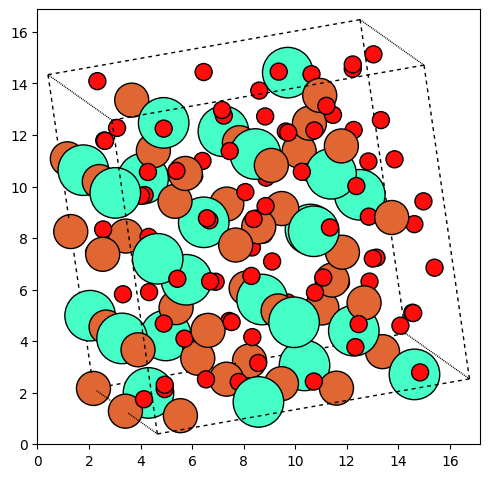

In [51]:
# Read the CIF file
atoms = read('Gd3Fe5O12.cif')

# Print basic structure information

print(f"Number of atoms per unit cell: {len(atoms)}")
print(f"Cell parameters: {atoms.cell.cellpar()}")

# Plot the structure
fig, ax = plt.subplots(figsize=(5, 5))
plot_atoms(atoms, ax, radii=0.5, rotation=('10x,10y,10z'))
plt.tight_layout()
plt.show()

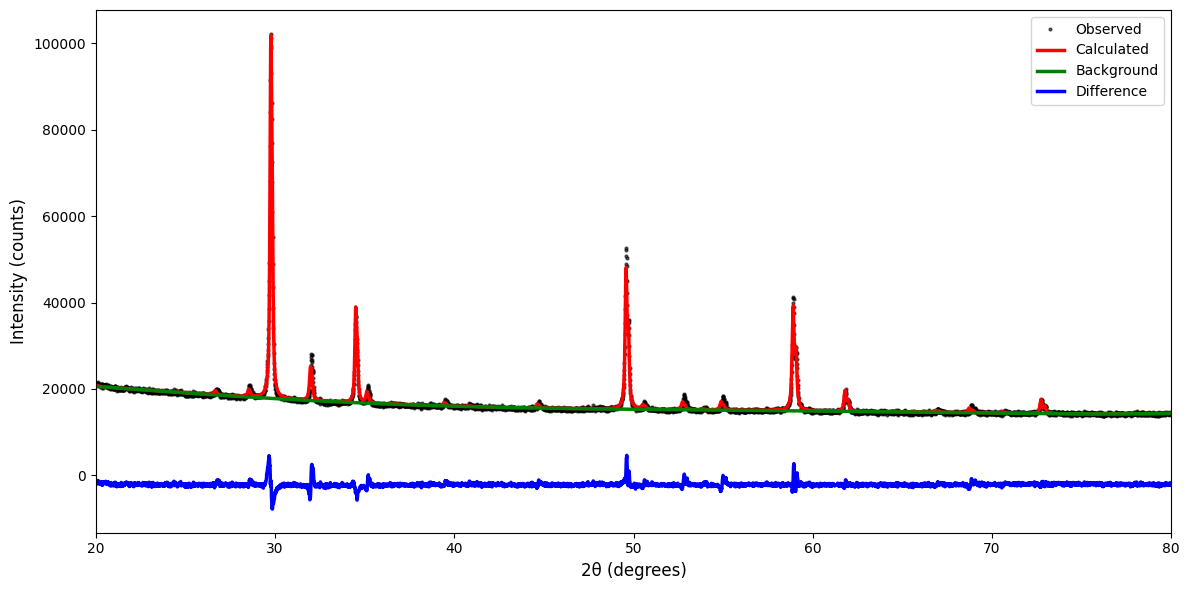

In [52]:
# Plot the experimenetal and and fit PXRD with multiple phases
plot_pxrd('stage2.csv')

Above we can see that adding the garnet phase to our data we were able to account for the extra peak at 32°, and fortunately, all the other peaks that were not coming from the defect-fluorite structure seem to have belonged to the garnet structure. Now that we've accounted for all the phases in our sample we can try analyzing their compositions.

**Note:** In a real Rietveld refinement the ratio of the phases is something you would need to figure out yourself. Based on the intensities the sample is mostly defect-fluorite with a little bit of the garnet also being produced. In the sample above, the weight % of each is 88.2% Gd<sub>2</sub>Zr<sub>2</sub>O<sub>7</sub> and 11.8% Gd<sub>3</sub>Fe<sub>5</sub>O<sub>12</sub>

In [53]:
# Calculate chi-squared for Stage 2
df = pd.read_csv('stage2.csv', sep=',')
obs = df['obs'].values
calc = df['calc'].values

print(f'Rwp: {calculate_rwp(obs, calc):.4f} ({calculate_rwp(obs, calc)*100:.2f}%)')
print(f'Rexp: {calculate_rexp(obs):.4f} ({calculate_rexp(obs)*100:.2f}%)')
print(f'chi-squared: {calculate_chi_squared(obs, calc):.4f}')

Rwp: 0.0295 (2.95%)
Rexp: 0.0078 (0.78%)
chi-squared: 14.4468


### Stage 3: Adding disorder

Earlier, we mentioned that the intensities of the peaks depend on structure factors which in turn depend on the atoms and their positions within the unit cell. Therefore it is possible to work backwards from the intensities and determine the contents of the unit cell. However, this should be done with caution because as we mentioned above, counting photons follows a Poisson distribution, so the y<sub>obs,i</sub> is not the same as the y<sub>true,i</sub>. The next example shows what can go wrong when you chase minimizing χ<sup>2</sup> and ignore the constraints of reality.

One of the parameters that can be refined is the site occupancies within the unit cell. We can add a Fe to the metal site of the defect-fluorite structure and now that site will be disordered with Gd, Zr, and Fe instead of just Gd and Zr.

In [ ]:
# Plot the experimenetal and calculated PXRD patterns
plot_pxrd('stage3.csv')

In [ ]:
# Calculate chi-squared for Stage 3
df = pd.read_csv('stage3.csv', sep=',')
obs = df['obs'].values
calc = df['calc'].values

print(f'Rwp: {calculate_rwp(obs, calc):.4f} ({calculate_rwp(obs, calc)*100:.2f}%)')
print(f'Rexp: {calculate_rexp(obs):.4f} ({calculate_rexp(obs)*100:.2f}%)')
print(f'chi-squared: {calculate_chi_squared(obs, calc):.4f}')

After refining the site occupancies of the sites the new crystallographic parameters for the defect-fluorite phase look like this:

| Label | Atom | x | y | z | Occupancy | Multiplicity |
| -- | -- | -- | -- | -- | -- | -- |
| Gd1 | Gd | 0 | 0 | 0 | **-0.5252** | 4 |
| Zr1 | Zr | 0 | 0 | 0 | **1.2160** | 4 |
| Fe1 | Fe | 0 | 0 | 0 | **1.1823** | 4 |
| O1 | O | 0.25 | 0.25 | 0.25 | **1.0254** | 8 |

Recall, the occupancies of the metal site originally summed to 100% and now we've exceeded 100% occupancy. Not a good sign! Also the occupancy of the oxygen site has jumped from 87.5% to over 100% as well.

Remember, the Rietveld refinement doen't care about what is physically possible. All it cares about is producing y<sub>calc,i</sub> that are as close to y<sub>obs,i</sub> as possible to minimize Σ(y<sub>calc,i</sub> - y<sub>obs,i</sub>)<sup>2</sup>.

### Stage 4: Stay in Reality

If you think back to your highschool chemistry classes one of the first things they teach is that your compounds need to be charge-balanced ie. if you add up all the oxidation states they should sum to 0.

Let's see if we can be more intelligent with how we figure out the occupancy of the metal sites rather than having the Rietveld refinement blindly try to change them until our calculated intensties match the observed intensities.

Recall that you can recover the chemical formula by finding the product of the site occupancy by the sites multiplicity.

**Hint**: The oxidation state of Fe is not 3+. You can find the other oxidation states if you look above at the precurors that were used in the reaction.  

In [ ]:
#@title **Solution:** Click to reveal

# oxidation states
Gd_ox = 3
Zr_ox = 4
Fe_ox = 2
O_ox = -2

# site occupancies
Gd_occ = 0.375
Zr_occ = 0.5625
Fe_occ = 0.0625
O_occ = 0.875

# site multiplicities
Gd_mult = 4
Zr_mult = 4
Fe_mult = 4
O_mult = 8

# Check for charge neutrality
net_charge = (Gd_ox*Gd_occ*Gd_mult +
              Zr_ox*Zr_occ*Zr_mult +
              Fe_ox*Fe_occ*Fe_mult +
              O_ox*O_occ*O_mult)

print(f"Net charge: {net_charge}")

# Print your chemical formula
print(f"Compound formula: Gd{Gd_occ*Gd_mult}Fe{Fe_occ*Fe_mult}Zr{Zr_occ*Zr_mult}O{O_occ*O_mult}")

In [ ]:
# Plot the experimenetal and calculated PXRD patterns
plot_pxrd('stage4.csv')

In [ ]:
# Calculate chi-squared for Stage 4
df = pd.read_csv('stage4.csv', sep=',')
obs = df['obs'].values
calc = df['calc'].values

print(f'Rwp: {calculate_rwp(obs, calc):.4f} ({calculate_rwp(obs, calc)*100:.2f}%)')
print(f'Rexp: {calculate_rexp(obs):.4f} ({calculate_rexp(obs)*100:.2f}%)')
print(f'chi-squared: {calculate_chi_squared(obs, calc):.4f}')

Using our intelligent strategy of assigning site occupancies our chi-squared got slightly worse (10.53 -> 10.67) but given that the former was not physically realistic at all this is a trade-off we'll gladly make.